In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.analysis import analysis

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')

In [4]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

### Prepare links for pathfinder

In [5]:
# Generate length for PT links as the crow flies
if 'length' not in sm.links.columns:
    tqdm.pandas()
    sm.links['length'] = sm.links['geometry'].progress_apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))

100%|████████████████████████████████████████████████████████████████████████| 384918/384918 [01:51<00:00, 3457.24it/s]


In [6]:
# Add average waiting time (half the headway) on links
if True:#'headway' not in sm.links.columns:
    sm.links['headway'] = 10*60*2
    # Air trips require security checks and so on...
    sm.links.loc[sm.links['route_type']=='air', 'headway'] = 45*60*2

In [7]:
sm.links.sample()

,a,b,route_type,geometry,link_sequence,route_id,time,trip_id,length,headway
index,,,,,,,,,,
coach_2651,coach_node_FLIXBUS:21,coach_node_FLIXBUS:28,coach,"LINESTRING (11.08550 49.44772, 9.93432 49.80161)",2,coach_FLIXBUS:028,6000,coach_FLIXBUS:028:10:10:30:00Z,133095,1200


In [8]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 217335 pairs


### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [9]:
'''This cell would run all possible mode combinations
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True, # Allow different mode combinations
    route_column='route_id',
    mode_column='route_type',
    boarding_time=0, # Assumption
    alighting_time=0,
    speedup=True,
    walk_on_road=False,
    keep_pathfinder=False, # Saves it as attribute for multiple iterations
    force=False, # If indices are inconsistent
    path_analysis=True, # Create path, time and length columns
    drop_duplicates=True, # Considering duplicate paths
    cutoff=np.inf, # distance limit between points for Dijkstra algorithm
    od_set=od_set) # Exclude OD pairs that are not used'''

"This cell would run all possible mode combinations\nsm.step_pt_pathfinder(\n    broken_routes=False,\n    broken_modes=True, # Allow different mode combinations\n    route_column='route_id',\n    mode_column='route_type',\n    boarding_time=0, # Assumption\n    alighting_time=0,\n    speedup=True,\n    walk_on_road=False,\n    keep_pathfinder=False, # Saves it as attribute for multiple iterations\n    force=False, # If indices are inconsistent\n    path_analysis=True, # Create path, time and length columns\n    drop_duplicates=True, # Considering duplicate paths\n    cutoff=np.inf, # distance limit between points for Dijkstra algorithm\n    od_set=od_set) # Exclude OD pairs that are not used"

In [10]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
# This step yields shortest paths regardless of the mode combination.
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=False,
    keep_pathfinder=True, # get the PPF
    mode_column='route_type',
    route_column='route_id',
    speedup=True,
    cutoff=np.inf,
    walk_on_road=False,
    od_set=od_set,
    path_analysis=False,
)
ppf = sm.publicpathfinder

In [11]:
len(sm.pt_los)

214089

In [12]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
ppf.mode_combinations = [x for x in ppf.mode_combinations
                         if not ('coach' in x and
                         ('rail_long_distance' in x or
                          'rail_short_distance' in x or
                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'rail_long_distance', 'rail_short_distance'},
 {'air', 'bus', 'rail_long_distance'},
 {'air', 'bus', 'rail_short_distance'},
 {'air', 'bus'},
 {'air', 'rail_long_distance', 'rail_short_distance'},
 {'air', 'rail_long_distance'},
 {'air', 'rail_short_distance'},
 {'air'},
 {'bus', 'coach'},
 {'bus', 'rail_long_distance', 'rail_short_distance'},
 {'bus', 'rail_long_distance'},
 {'bus', 'rail_short_distance'},
 {'bus'},
 {'coach'},
 {'rail_long_distance', 'rail_short_distance'},
 {'rail_long_distance'},
 {'rail_short_distance'},
 set()]

In [13]:
# Run the pathfinder for all mode combinations
ppf.find_broken_mode_paths(workers=3, # CPU cores
                           cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type')

breaking modes: set() : 100%|█████████████████████████████████████████████████████████| 18/18 [42:12<00:00, 140.68s/it]


In [14]:
ppf.broken_mode_paths.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes
118369,DE929_1,DE735,14327.694118,"[DE929_1, rail_short_node_14970, rail_short_43...",False,mode_breaker,{rail_long_distance}


In [15]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|███████████████████████████████████████████████████████| 3313481/3313481 [06:26<00:00, 8575.33it/s]


In [16]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample(3)

3313481


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
98588,DE724,DE147,15792.317647,"[DE724, rail_long_node_120, rail_short_node_10...",False,mode_breaker,"{rail_short_distance, rail_long_distance}","[coach_node_FLIXBUS:1564, FRA]","[coach_node_FLIXBUS:38, FDH]","[rail_long_node_120, rail_short_node_10059, co...","[coach_6289, coach_6290, air_32]","[(rail_long_node_120, rail_short_node_10059), ...","[(DE724, rail_long_node_120), (FDH, DE147)]",[],"[coach_6289, air_32]","[coach_6290, air_32]",False,1,8400,370189
85490,DE40F,DE12A,34756.658824,"[DE40F, rail_short_node_13029, rail_short_1200...",False,mode_breaker,"{rail_long_distance, air, bus}","[rail_short_node_13029, rail_short_node_7084, ...","[rail_short_node_7084, rail_short_node_257, co...","[rail_short_node_13029, rail_short_node_7084, ...","[rail_short_120011, rail_short_120012, rail_sh...","[(rail_short_node_257, coach_node_FLIXBUS:2068...","[(DE40F, rail_short_node_13029), (rail_short_n...","[rail_short_node_7084, coach_node_FLIXBUS:37111]","[rail_short_120011, rail_short_10073, coach_11...","[rail_short_120013, rail_short_10083, coach_11...",False,6,27360,1008104
215044,DEG0J,DE80J_2,16366.270588,"[DEG0J, bus_n_118350, bus_1000677, bus_n_4789,...",False,mode_breaker,{air},"[bus_n_118350, bus_n_119999, rail_long_node_50...","[bus_n_4789, bus_n_46513, rail_long_node_143, ...","[bus_n_118350, bus_n_4789, rail_long_node_1316...","[bus_1000677, bus_195187, rail_long_5210, rail...","[(bus_n_4789, rail_long_node_1316), (rail_long...","[(DEG0J, bus_n_118350), (rail_long_node_714, D...","[rail_long_node_143, rail_long_node_313]","[bus_1000677, bus_195187, rail_long_5210, rail...","[bus_1000677, bus_195187, rail_long_5210, rail...",False,4,12300,464708


### Add attributes to LoS table

In [17]:
# Disaggregate time into in-vehicle and access/egress
sm.analysis_pt_time(boarding_time=0)
print(sm.pt_los.columns)

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'access_time', 'footpath_time',
       'in_vehicle_time', 'waiting_time', 'boarding_time', 'time'],
      dtype='object')


In [18]:
# Add price, parametrisation comes later
sm.pt_los['price'] = 0

In [19]:
# Add distances
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [20]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [21]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long_distance', 'rail_short_distance', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [22]:
# Add number of transfers
#sm.pt_los['ntransfers'] = sm.pt_los['boardings'].apply(lambda l: max(0, len(l) - 1))

In [23]:
sm.pt_los.sample(2)

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,price,length,route_types,route_type
133912,DEA11,DEB18,13616.623529,"[DEA11, rail_long_node_731, rail_long_200, rai...",False,mode_breaker,"{coach, bus}","[rail_long_node_731, rail_short_node_2446, rai...","[rail_long_node_238, rail_short_node_13151, ra...","[rail_long_node_731, rail_long_node_238, rail_...",...,1267.623529,0,6540,2400.0,0,10207.623529,0,179840,"{rail_short_distance, rail_long_distance}",rail_long_distance
184257,DED2C_1,DE934,19725.000000,"[DED2C_1, bus_n_49163, bus_1529523, bus_152952...",False,mode_breaker,{air},"[bus_n_49163, bus_n_19090, bus_n_126421, bus_n...","[bus_n_23918, bus_n_126421, bus_n_300075, bus_...","[bus_n_49163, bus_n_23918, coach_node_FLIXBUS:...",...,504.000000,861,12960,5400.0,0,19725.000000,0,642189,"{rail_short_distance, bus}",rail_short_distance


In [24]:
# Make a copy before restricting results
los = sm.pt_los.copy()

### Clean PT LOS

In [25]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long_distance' in x or 'rail_short_distance' in x or 'air' in x))]
sm.pt_los.shape

(2484391, 30)

In [26]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<10*3600]
sm.pt_los.shape

(2475807, 30)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

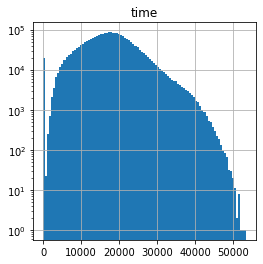

In [27]:
# Time distribution
sm.pt_los.hist(column='time', bins=100, figsize=(4,4), log=True)

In [28]:
'''# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth(0)'''
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(inplace=True)
sm.pt_los.shape

(1948478, 31)

array([[<AxesSubplot:title={'center':'time'}>]], dtype=object)

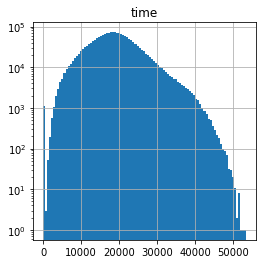

In [29]:
sm.pt_los.hist(column='time', bins=100, figsize=(4,4), log=True)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

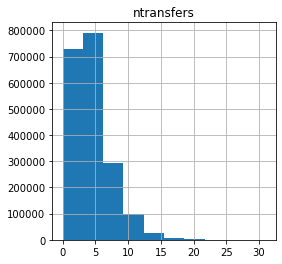

In [30]:
sm.pt_los.hist(column='ntransfers', figsize=(4,4))

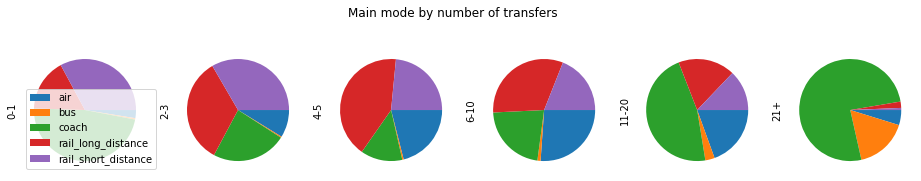

In [31]:
# Main mode distribution
t = sm.pt_los.copy()
t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                   labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by number of transfers',
    legend=False, labeldistance=None)
axs[0].legend(loc='lower left')

In [32]:
# Drop unnecessary long connections
if sm.links['headway'].mean() > 5*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<20]
    print(sm.pt_los.shape)

(1947259, 31)


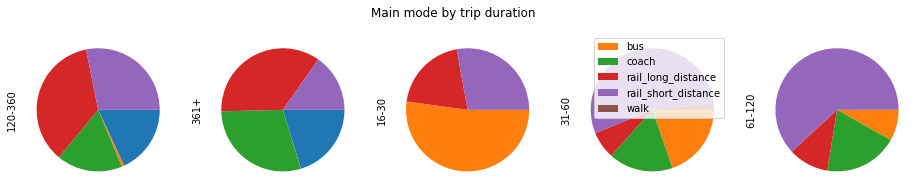

In [33]:
t['time'] = t['time'] / 60
t['bins'] = pd.cut(t['time'], bins=[0,15,30,60,120,360,500],
                   labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
    subplots=True, figsize=(16, 3),
    startangle=0, counterclock=False, title='Main mode by trip duration',
    legend=False, labeldistance=None)
axs[-2].legend()

In [34]:
t = None

In [35]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [36]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [37]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [38]:
sm.pt_los.sample()

,index,origin,destination,link_path,ntransfers,access_time,footpath_time,in_vehicle_time,waiting_time,time,price,length,route_types,route_type
173009,138885,DEA1C,DE40H,"[rail_short_73417, rail_short_73418, rail_shor...",3,2450,0,20040,2400,24890,0,874007,{rail_short_distance},rail_short_distance


### Save model

In [39]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [01:03<00:00,  1.77s/it]


In [40]:
# Split links in graph and auxiliary information
# for file sizes being compatible with github's size limit
cols = ['link_sequence', 'route_id', 'time', 'trip_id', 'length', 'headway']
auxiliary = sm.links[cols]
sm.links.drop(cols, axis=1, inplace=True)

In [41]:
sm.to_json(model_path + 'de_pt_network_agg', only_attributes=[
    'zones', 'links', 'nodes', 'pt_route_types'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 36/36 [00:55<00:00,  1.55s/it]


In [42]:
# Save auxiliary information seperately
auxiliary['index'] = auxiliary.index
auxiliary.reset_index(drop=True, inplace=True)
auxiliary.to_json(model_path + 'de_pt_network_agg/links_quetzaldata.json')